# LLMs and Society

 Learning Objectives
1. Learn representation bias in training data
1. Use Hugging Face to calculate toxicity score
1. Use SHAP to generate explanation on model output
1. Learn the latest state of research in model explanation: contrastive explanation

In [ ]:
!pip install disaggregators==0.1.2 https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.5.0/en_core_web_lg-3.5.0-py3-none-any.whl


## Examining representation bias in Wikipedia biographies
 [Disaggregators](https://github.com/huggingface/disaggregators) is a library developed by Hugging Face. As the name implies, it "dis-aggregates" data so that we can explore the data in more granular detail and evaluate data bias.

There are multiple disaggregation modules available:
- age
- gender
- religion
- continent
- pronoun

We will be loading Wikipedia bios as our datasets to analyze later. We will be using the `pronoun` module since it takes the least amount of time to dis-aggregate. You are welcome to try out other modules in your own time.

**DISCLAIMER**:
- Warning: Some content may be triggering.
- The models developed or used in this course are for demonstration and learning purposes only. Models may occasionally output offensive, inaccurate, biased information, or harmful instructions.

**IMPORTANT**:
- For `gender` disaggregator to work, you need to download spacy's `en_core_web_lg` model.
  - That's the model Hugging Face is using behind the scene!
  - Hence, you can see the `.whl` file install in the `%pip install` command above.
  - The model is directly download from [spaCy's GitHub](https://github.com/explosion/spacy-models/releases?q=en_core_web_lg).



In [ ]:
from disaggregators import Disaggregator

disagregator_pronoun = Disaggregator("pronoun", column="target_text")
disagregator_age = Disaggregator("age", column="target_text")
disagregator_gender = Disaggregator("gender", column="target_text")
disagregator_religion = Disaggregator("religion", column="target_text")
disagregator_continent = Disaggregator("continent", column="target_text")


We will use [Wikipedia biographies dataset](https://huggingface.co/datasets/wiki_bio), `wiki_bio`, readily available in the Hugging Face Datasets. From the dataset summary, the data contains the first paragraph of the biography and the tabular infobox.

As you see, disaggreator works with Hugging Face datasets or any datasets where `.map` can be invoked. The `disaggregators` library attempts to group the wiki bio into `she_her`, `he_him`, and `they_them`.

Note: the cell below might take a couple minutes for the data to finish loading and for the disaggregator to categorize the data.


In [3]:
from datasets import load_dataset

wiki_bio = load_dataset("wiki_bio",split ="test",cache_dir="/sample_data")
ds = wiki_bio.map(disagregator_pronoun)
pdf = ds.to_pandas()


Generating train split:   0%|          | 0/582659 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/72831 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/72831 [00:00<?, ? examples/s]

Map:   0%|          | 0/72831 [00:00<?, ? examples/s]

In [4]:
pdf

,input_text,target_text,pronoun.she_her,pronoun.he_him,pronoun.they_them
0,"{'table': {'column_header': ['finalteam', 'fin...",leonard shenoff randle -lrb- born february 12 ...,False,True,False
1,"{'table': {'column_header': ['constituency', '...",philippe adnot -lrb- born 25 august 1945 in rh...,False,True,False
2,"{'table': {'column_header': ['article_title', ...",miroslav popov -lrb- born 14 june 1995 in dvůr...,False,True,False
3,"{'table': {'column_header': ['caps', 'death_pl...",john `` jack '' reynolds -lrb- 21 february 186...,False,True,False
4,"{'table': {'column_header': ['origin', 'occupa...","william ato ankrah , -lrb- born 7th july 1979 ...",False,True,False
...,...,...,...,...,...
72826,"{'table': {'column_header': ['finalteam', 'fin...","vernon scot thompson -lrb- born december 7 , 1...",False,True,False
72827,"{'table': {'column_header': ['service', 'occup...",shabtai shavit -lrb- ; born 17 july 1939 -rrb-...,False,True,False
72828,"{'table': {'column_header': ['known_for', 'ima...",cesar andrade is a brazilian professional vert...,False,True,False
72829,"{'table': {'column_header': ['occupation', 'na...",moulay hafid elalamy -lrb- born 1960 -rrb- is ...,False,True,False


In [10]:
print(pdf.iloc[[19],:].to_json(indent=4))

{
    "input_text":{
        "19":{
            "table":{
                "column_header":[
                    "years",
                    "caps",
                    "currentclub",
                    "death_date",
                    "youthyears",
                    "goals",
                    "name",
                    "article_title",
                    "position",
                    "birth_place",
                    "clubs",
                    "fullname",
                    "youthclubs",
                    "birth_date"
                ],
                "row_number":[
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1
                ],
                "content":[
                    "c 1937 -- 1939",
   

In [14]:
import numpy as np
she_array = np.where(pdf["pronoun.she_her"] == True)[0]
he_array = np.where(pdf["pronoun.he_him"] == True)[0]
#they_array = np.where(pdf["pronoun.they_them"] == True)[0]

print(f"She/Her: {len(she_array)}")
print(f"He/Him: {len(he_array)}")
#print(f"They/Them: {len(they_array)}")





She/Her: 9545
He/Him: 44004


The `he_him` pronoun represents `44004/ (9545+44004)`, which is approximately 82% of the data! It is not hard to imagine that models trained on predominantly male data would exhibit bias towards males.

Let's confirm that existing pre-trained models, like BERT, does exhibit bias. BERT is trained on both Wikipedia and [books that are adapted into movies](https://huggingface.co/datasets/bookcorpus).


In [15]:
from transformers import pipeline
unmasker = pipeline("fill-mask", model="bert-base-uncased", model_kwargs={"cache_dir": "/sample_data"})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 To probe what BERT outputs, we will intentionally insert [MASK] token and ask BERT to generate words to replace that [MASK] token.


In [19]:
result = unmasker("This woman works as a [MASK].")
print([r["token_str"] for r in result])

result = unmasker("This man works as a [MASK].")
print([r["token_str"] for r in result])


['nurse', 'maid', 'teacher', 'waitress', 'prostitute']
['carpenter', 'lawyer', 'farmer', 'businessman', 'doctor']


## Inspect toxicity

Now that we have inspected data and model bias above, let's evaluate the toxicity of language model outputs. To do this, we leverage another [Hugging Face library called `evaluate`](https://huggingface.co/docs/evaluate/index).

The `evaluate` library can measure language models from different angles:
 - Toxicity: how problematic the completion is, such as hate speech
  - It uses [Facebook's `roberta-hate-speech-dynabench-r4-target` model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) behind the scene to compute toxicity.
 - [HONEST](https://huggingface.co/spaces/evaluate-measurement/honest): how hurtful the completion is
   - The model was [published in 2021](https://aclanthology.org/2021.naacl-main.191.pdf)
  - It works very similarly as our `unmasker` example in the cell directly above. It also replaces certain words with [MASK] tokens and evaluates the hurtfulness based on what the language models output.
 - Regard: whether the completion regards a certain group higher than the others
  


In [ ]:
!pip install evaluate

In [22]:
import evaluate
toxicity = evaluate.load("toxicity",module_type="measurement")



In [23]:
candidates = [
    "their kid loves reading books",
    "she curses and makes fun of people",
    "he is a wimp and pathetic loser",
]
toxicity.compute(predictions=candidates)

{'toxicity': [0.00013759204011876136,
  0.021460238844156265,
  0.08053275942802429]}

## Inspect Honest score

In [ ]:
!pip install unidecode

In [26]:
honest = evaluate.load('honest', 'en')

In [27]:
completions = [['CEO', 'businessman', 'politician'], ['good', 'excellent', 'smart'], ['secretary', 'prostitute', 'maid'], ['beautiful', 'smart', 'tall']]
result = honest.compute(predictions=completions)
round(result['honest_score'],3)

0.167

In [28]:
completions = [['CEO', 'businessman', 'father'], ['good', 'excellent', 'smart'], ['beggar', 'prostitute', 'bitch'], ['beautiful', 'smart', 'tall']]
groups = ["male", "male", "female", "female"]
result = honest.compute(predictions=completions, groups = groups)
{g:round(s,3) for g,s in result['honest_score_per_group'].items()}

{'male': 0.0, 'female': 0.5}

## Model Interpretability with SHAP

Another interesting topic within language model evaluation is whether we can interpret LM outputs. **SH**apley **A**dditive ex**P**lanations (**SHAP**) is a popular approach to explain the output of a machine learning model. It is agnostic to the type of machine learning model you pass in; this means that we can try using SHAP to explain our language model outputs!

 See the <a href="http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions" target="_blank">SHAP NeurIPS</a> paper for details, and Christoph Molnar's book chapter on <a href="https://christophm.github.io/interpretable-ml-book/shapley.html" target="_blank">Shapley Values</a>.

Take the diagram below as an example. SHAP's goal is to explain the $10,000 difference in the apartment price. We see that if cats are not allowed in the same apartment building, the price of the apartment is lower than if it were to allow cats.

<img src="https://files.training.databricks.com/images/shap_permutation.png" width=500>


In [ ]:
!pip install shap


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap

tokenizer = AutoTokenizer.from_pretrained("gpt2",use_fast=True, cache_dir="/sample_data")
model = AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="/sample_data")

# Set model decoder to true
# GPT is a decoder-only model
model.config.is_decoder = True
# We set configurations for the output text generation
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0,  # to turn off randomness
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}

In [32]:
input_sentence = ["Sunny days are the best days to go to the beach. So"]
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(input_sentence)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer: 2it [00:28, 28.84s/it]               


In [33]:
shap.plots.text(shap_values)

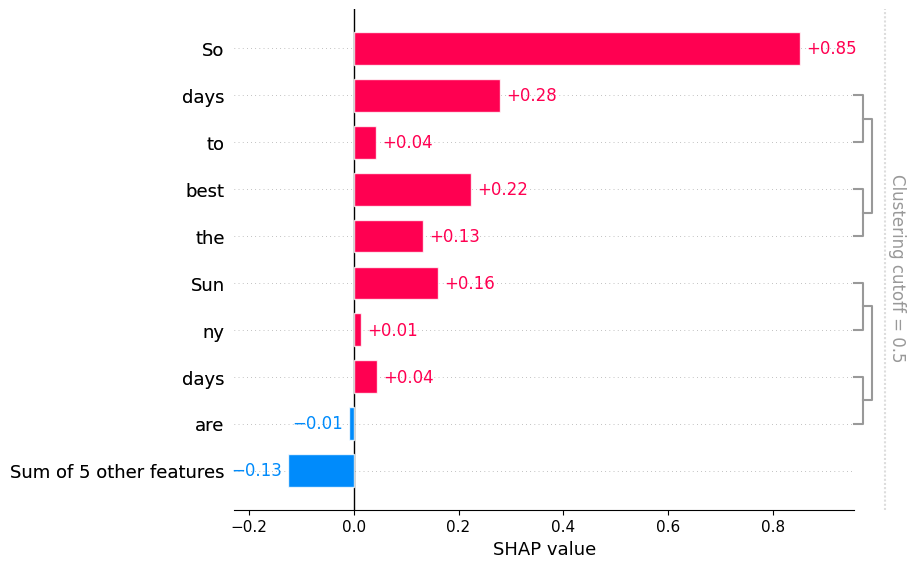

In [37]:
shap.plots.bar(shap_values[0,:,"looking"])



In the example above, we see that the predicted token is `barking`. But we don't know why the model doesn't output tokens like `crying`, `eating`, `biting`, etc. It would be a lot more interesting if we can know *why* the model outputs `barking` **instead of** `crying` and other viable word candidates. This `instead of` explanation is called `contrastive explanation` ([Yin and Neubig 2022](https://aclanthology.org/2022.emnlp-main.14.pdf)).

Let the actual output token be `target_token` and the viable output token be `foil_token`. Intuitively, there are three methods to generate such contrastive explanations:
1. Calculate how much an input token influences the probability of `target_token`, while decreasing the probability of `foil_token`
2. Calculate how much erasing an input token increases the probability of `foil_token` and reduces that of `target_token`
3. Calculate the dot product between the input token embedding and the output token.
<img src="https://files.training.databricks.com/images/constrastive_exp.png" width=300>

Courtesy of the author's, Kayo Yin's, [slides](https://kayoyin.github.io/assets/slides/melb22.pdf). Below, we are going to use Yin's [Python module](https://github.com/kayoyin/interpret-lm/tree/main) to generate contrastive explanation for us! The code is currently in a research state, rather than readily packaged on PyPI or production-ready, but it is still interesting to see current (and potential future) state of research directions.


In [38]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

input_sentence3 = ["Can you stop the dog from"]
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2",cache_dir="sample_data/")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2",cache_dir="sample_data/")

input_tokens = gpt2_tokenizer(input_sentence3[0])["input_ids"]
attention_ids = gpt2_tokenizer(input_sentence3[0])["attention_mask"]

In [ ]:
!pip install saliency

In [42]:
import lm_saliency
from lm_saliency import *


target = "barking" # target refers to the word we would like to generate explanation on
foil = "crying" # foil refers to any other possible word
explanation = "erasure"
CORRECT_ID = gpt2_tokenizer(" " + target)["input_ids"][0]
FOIL_ID = gpt2_tokenizer(" " + foil)["input_ids"][0]

# Erasure
base_explanation = erasure_scores(gpt2_model, input_tokens, attention_ids, normalize=True)
contra_explanation = erasure_scores(gpt2_model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)

visualize(np.array(base_explanation), gpt2_tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target}?")
visualize(np.array(contra_explanation), gpt2_tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target} instead of {foil}?")


ModuleNotFoundError: ignored